In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# pd.set_option('display.max_rows', 100, 'display.min_rows', 20)

In [2]:
plt.rcParams['figure.figsize']=(15,10)

In [3]:
crsp = pd.read_csv('crsp_filtered2.csv')
crsp.head()

,Unnamed: 0,date,permno,prc,ret,relvol,size,prc_clipped,relvol_clipped,size_clipped,tgt_ret,tgt_label,mom3m,mom6m,mom12m,sz_cat,tgt_label2
0,12,2001-01-31,80000,20.1250,0.025478,0.052441,11.180602,20.1250,0.052441,11.180602,-0.003106,3.0,0.019481,0.226563,0.171642,5,0.0
1,13,2001-02-28,80000,20.0625,-0.003106,0.023352,11.151626,20.0625,0.023352,11.151626,0.099688,1.0,0.080537,0.183824,0.229008,5,1.0
2,14,2001-03-30,80000,22.0625,0.099688,0.072649,11.244636,22.0625,0.072649,11.244636,-0.027989,6.0,0.022293,0.163043,0.360169,5,-1.0
3,15,2001-04-30,80000,21.4450,-0.027989,0.055857,11.216248,21.4450,0.055857,11.216248,0.010026,5.0,0.096273,0.146104,0.548246,5,1.0
4,16,2001-05-31,80000,21.6600,0.010026,0.025983,11.231117,21.6600,0.025983,11.231117,-0.021237,5.0,0.068910,0.151409,0.394797,5,-1.0


In [4]:
# train set: ~ 2009-12-31
# test set: 2010-01-01 ~
train = crsp[crsp.date < '2010-01-01']
test = crsp[crsp.date >= '2010-01-01']

x_cols = ['mom3m','mom6m','mom12m', "ret", "size_clipped", "relvol_clipped", "prc_clipped"] # input features
x_train = train[x_cols]
y_train = train['tgt_label2']
x_test = test[x_cols]
y_test = test['tgt_label2']

In [5]:
from sklearn.neighbors import KNeighborsClassifier

In [6]:
clf = KNeighborsClassifier(2000)

In [7]:
clf.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=2000)

In [8]:
# in-sample (train set) accuracy
clf.score(x_train, y_train) 

# out-of-sample (test set) accuracy
a = clf.score(x_test, y_test)
print(a)

0.49541155703113127

0.5056439901502024


In [10]:
# 'W' and 'L' portfolio returns
r_w_ew = []; r_l_ew = []  # equal-weight 
r_w_vw = []; r_l_vw = []  # value-weight

# predict in each month during the test period
for m, test_m in test.groupby('date'):
    x_test_m = test_m[x_cols].values
    
    # Predict the return class
    y_pred = clf.predict(x_test_m)
    widx = y_pred==1 # highest return class
    lidx = y_pred==-1 # lowest return class
    
    rw = test_m.loc[widx, 'tgt_ret'] # returns of class 'W'
    rl = test_m.loc[lidx, 'tgt_ret'] # returns of class 'L'
    
    print(f'{m} Number of stocks in W and L: {len(rw)}, {len(rl)}')

    # equal-weight
    # portfolio weights
    ww_ew = (1/len(rw) if len(rw) else 0) * np.ones_like(rw)
    wl_ew = (1/len(rl) if len(rl) else 0) * np.ones_like(rl)
    
    # portfolio return
    r_w_ew.append(np.matmul(ww_ew, rw))
    r_l_ew.append(np.matmul(wl_ew, rl))

    # value-weight
    # portfolio weights
    sizew = np.exp(test_m.loc[widx, 'size'])
    sizel = np.exp(test_m.loc[lidx, 'size'])
    ww_vw = sizew/np.sum(sizew)
    wl_vw = sizel/np.sum(sizel)

    # portfolio return
    r_w_vw.append(np.matmul(ww_vw, rw))
    r_l_vw.append(np.matmul(wl_vw, rl))
    

r_w_ew = np.array(r_w_ew)
r_l_ew = np.array(r_l_ew)
# long-short portfolio return
r_wl_ew = r_w_ew - r_l_ew 

r_w_vw = np.array(r_w_vw)
r_l_vw = np.array(r_l_vw)
# long-short portfolio return
r_wl_vw = r_w_vw - r_l_vw

2010-01-29 Number of stocks in W and L: 1474, 73
2010-02-26 Number of stocks in W and L: 1492, 60
2010-03-31 Number of stocks in W and L: 1555, 65
2010-04-30 Number of stocks in W and L: 1615, 48
2010-05-28 Number of stocks in W and L: 1551, 36
2010-06-30 Number of stocks in W and L: 1472, 51
2010-07-30 Number of stocks in W and L: 1477, 67
2010-08-31 Number of stocks in W and L: 1433, 63
2010-09-30 Number of stocks in W and L: 1449, 94
2010-10-29 Number of stocks in W and L: 1507, 68
2010-11-30 Number of stocks in W and L: 1535, 59
2010-12-31 Number of stocks in W and L: 1591, 60
2011-01-31 Number of stocks in W and L: 1603, 45
2011-02-28 Number of stocks in W and L: 1591, 44
2011-03-31 Number of stocks in W and L: 1583, 53
2011-04-29 Number of stocks in W and L: 1570, 61
2011-05-31 Number of stocks in W and L: 1546, 65
2011-06-30 Number of stocks in W and L: 1557, 60
2011-07-29 Number of stocks in W and L: 1521, 67
2011-08-31 Number of stocks in W and L: 1485, 58
2011-09-30 Number of

In [11]:
r_w_ew

array([ 0.04390798,  0.07841118,  0.05154024, -0.07496031, -0.06868813,
        0.06655374, -0.06254929,  0.11808267,  0.04649066,  0.02974973,
        0.0807894 ,  0.00483751,  0.04841583,  0.0236228 ,  0.02465183,
       -0.01927742, -0.02090414, -0.03435237, -0.08817873, -0.11030519,
        0.14794485, -0.01195162, -0.00147911,  0.08205195,  0.03817648,
        0.02592824, -0.012935  , -0.07187534,  0.04551005, -0.01288984,
        0.03759591,  0.03397458, -0.01757257,  0.00933138,  0.03023027,
        0.06387727,  0.00651601,  0.04619004, -0.00134189,  0.04518603,
       -0.00068016,  0.07146578, -0.02239697,  0.06051013,  0.0255715 ,
        0.04477681,  0.02526174, -0.02488661,  0.04656903,  0.00171893,
       -0.03073422,  0.01058835,  0.04635974, -0.04425686,  0.04581343,
       -0.04967117,  0.04435837,  0.00587989,  0.0181791 , -0.046759  ,
        0.06392611,  0.00689012,  0.00253635,  0.01136962,  0.00952935,
       -0.0192099 , -0.04693961, -0.04943021,  0.06104102,  0.02

In [12]:
def evaluate(r_p):
    cum_r = (1 + r_p).prod()-1
    mean_r = np.mean(r_p)
    std_r = np.std(r_p)
    sharpe =  mean_r / std_r

    return [cum_r, mean_r, std_r, sharpe]

In [13]:
# dataframe to store evaluation results
pftab = pd.DataFrame(0, index=['cum', 'mean', 'std', 'Sharpe'], columns=[])

pftab['EW_W'] = evaluate(r_w_ew)
pftab['EW_L'] = evaluate(r_l_ew)
pftab['EW_WL'] = evaluate(r_wl_ew)

pftab['VW_W'] = evaluate(r_w_vw)
pftab['VW_L'] = evaluate(r_l_vw)
pftab['VW_WL'] = evaluate(r_wl_vw)

pftab

,EW_W,EW_L,EW_WL,VW_W,VW_L,VW_WL
cum,2.210681,1.735792,0.065233,2.109650,1.552700,-0.030958
mean,0.012064,0.011120,0.000944,0.011606,0.011040,0.000566
std,0.044768,0.056261,0.026364,0.041141,0.065545,0.041716
Sharpe,0.269472,0.197648,0.035798,0.282100,0.168431,0.013574


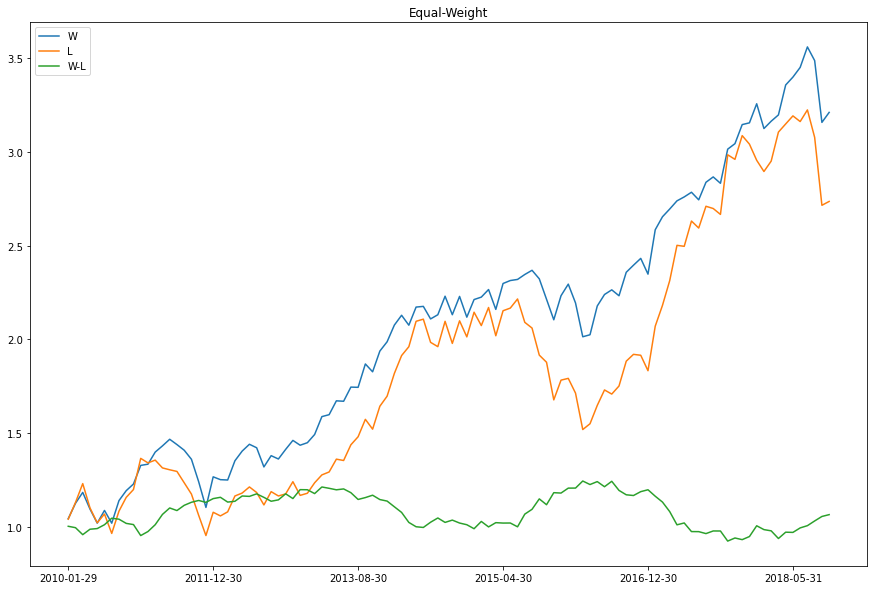

In [14]:
cumret = pd.DataFrame(0, index=test.date.unique(), columns=[])
cumret['W'] = (1 + r_w_ew).cumprod()
cumret['L'] = (1 + r_l_ew).cumprod()
cumret['W-L'] = (1 + r_wl_ew).cumprod()

cumret.plot(title='Equal-Weight')

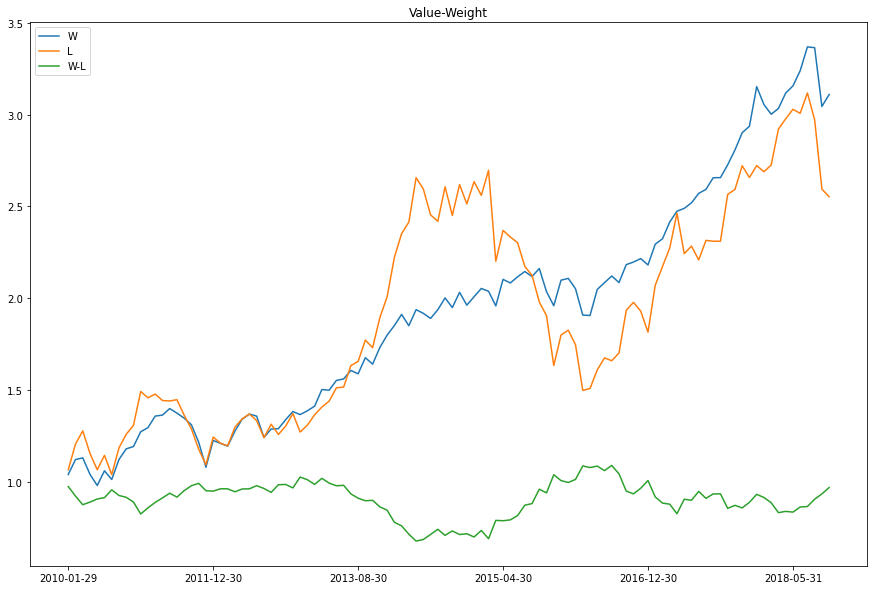

In [15]:
cumret = pd.DataFrame(0, index=test.date.unique(), columns=[])
cumret['W'] = (1 + r_w_vw).cumprod()
cumret['L'] = (1 + r_l_vw).cumprod()
cumret['W-L'] = (1 + r_wl_vw).cumprod()

cumret.plot(title='Value-Weight')